# **1: Install Libraries and Import Modules**

In [1]:
# Install required libraries
!pip install nltk scikit-learn pandas numpy matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import pickle
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import os
from google.colab import drive
import time

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# **2: Mount Google Drive and Load Resources**

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

print("Libraries installed and resources loaded successfully!")

Mounted at /content/drive
Libraries installed and resources loaded successfully!


# **3: Load and Explore Data**

Loading data from /content/drive/MyDrive/dataset/emotions.csv...

--- Data Overview ---
Dataset shape: (432809, 2)

First few rows:
                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

--- Emotion Distribution ---
emotion
joy         146429
sadness     125853
anger        59476
fear         49649
love         35858
surprise     15544
Name: count, dtype: int64


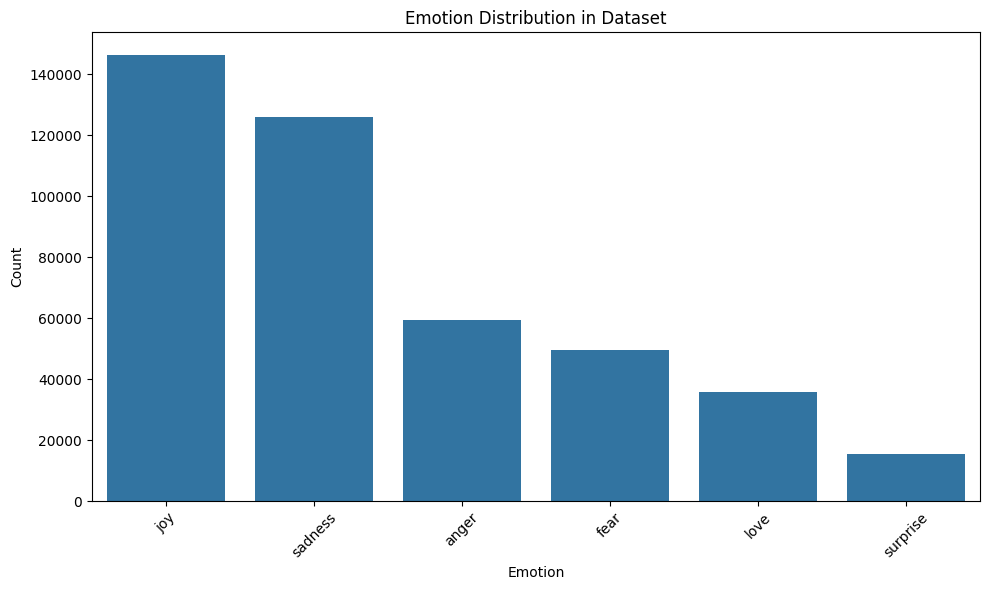


--- Text Length Statistics ---
count    432809.000000
mean         97.021647
std          56.187363
min           2.000000
25%          54.000000
50%          86.000000
75%         128.000000
max         830.000000
Name: text_length, dtype: float64


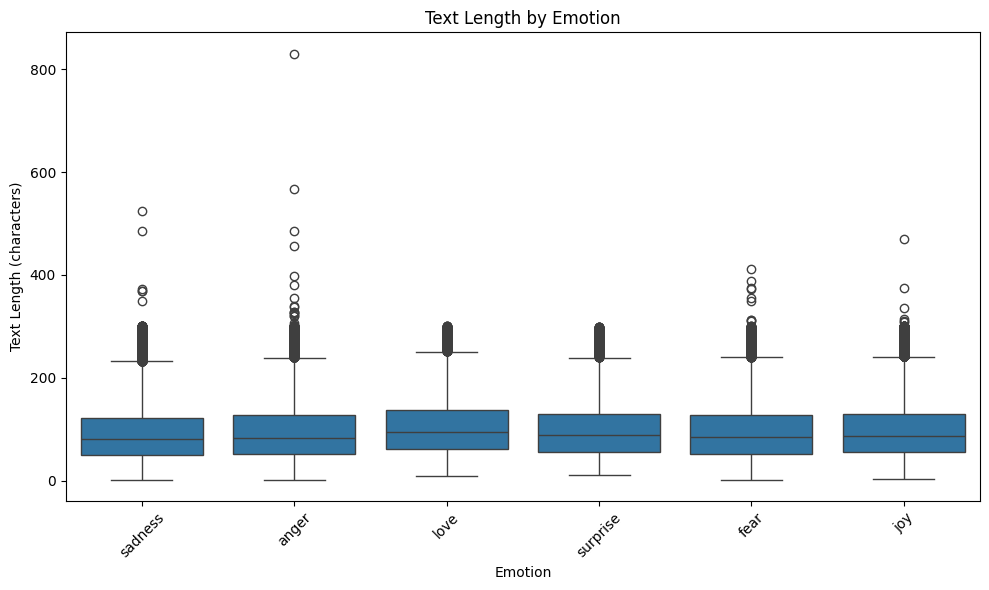

In [3]:
# Define data loading function with error handling
def load_data(file_path):
    """Load the emotion dataset from Google Drive with validation"""
    try:
        print(f"Loading data from {file_path}...")
        data = pd.read_csv(file_path)

        # Validate data structure
        required_columns = ['text', 'emotion']
        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            raise ValueError(f"Data file missing required columns: {missing_columns}")

        # Check for null values
        null_counts = data[required_columns].isnull().sum()
        if null_counts.any():
            print(f"Warning: Found null values in the dataset:\n{null_counts}")
            print("Removing rows with null values...")
            data = data.dropna(subset=required_columns)

        return data
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

# Specify the path to your dataset in Google Drive
data_path = '/content/drive/MyDrive/dataset/emotions.csv'

# Load the data
data = load_data(data_path)

# Explore the data
def explore_data(data):
    """Perform exploratory analysis on the dataset"""
    print("\n--- Data Overview ---")
    print(f"Dataset shape: {data.shape}")
    print("\nFirst few rows:")
    print(data.head())

    print("\n--- Emotion Distribution ---")
    emotion_counts = data['emotion'].value_counts()
    print(emotion_counts)

    # Visualize emotion distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
    plt.title('Emotion Distribution in Dataset')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/emotion_distribution.png')
    plt.show()

    # Text length analysis
    data['text_length'] = data['text'].apply(len)

    print("\n--- Text Length Statistics ---")
    print(data['text_length'].describe())

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='emotion', y='text_length', data=data)
    plt.title('Text Length by Emotion')
    plt.xlabel('Emotion')
    plt.ylabel('Text Length (characters)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/text_length_by_emotion.png')
    plt.show()

    return emotion_counts

emotion_counts = explore_data(data)

# **4: Text Preprocessing**

In [4]:
# Enhanced text cleaning function
def clean_text(text):
    """Clean text by removing special characters, extra spaces, and normalizing"""
    if not isinstance(text, str):
        text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove emojis and special characters
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Enhanced text preprocessing function with caching
lemmatizer = WordNetLemmatizer()
eng_stopwords = set(stopwords.words('english'))
preprocessing_cache = {}

def preprocess_text(text):
    """Preprocess text with tokenization, stopword removal, and lemmatization with caching"""
    if text in preprocessing_cache:
        return preprocessing_cache[text]

    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in eng_stopwords]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    processed_text = ' '.join(tokens)
    preprocessing_cache[text] = processed_text
    return processed_text

# Improved data preprocessing function
def preprocess_data(data):
    """Apply preprocessing to the dataset with progress tracking"""
    print("Preprocessing texts...")
    start_time = time.time()
    data['processed_text'] = data['text'].apply(preprocess_text)
    emotion_mapping = {emotion: i for i, emotion in enumerate(sorted(data['emotion'].unique()))}
    data['emotion_id'] = data['emotion'].map(emotion_mapping)
    end_time = time.time()
    print(f"Preprocessing completed in {end_time - start_time:.2f} seconds")
    print(f"Vocabulary size (unique words): {len(set(' '.join(data['processed_text']).split()))}")
    return data, emotion_mapping

# Preprocess the data
data, emotion_mapping = preprocess_data(data)

# Show preprocessing results
print("\nPreprocessing sample:")
sample_idx = np.random.randint(0, len(data))
print(f"Original: {data.iloc[sample_idx]['text']}")
print(f"Processed: {data.iloc[sample_idx]['processed_text']}")
print(f"Emotion: {data.iloc[sample_idx]['emotion']}")

Preprocessing texts...
Preprocessing completed in 78.36 seconds
Vocabulary size (unique words): 67683

Preprocessing sample:
Original: im feeling the aching joints and learning to take the pills and wondering if side effects are coming
Processed: im feeling aching joint learning take pill wondering side effect coming
Emotion: sadness


# **5: Model Building and Training**

Training set size: 346247
Test set size: 86562
Performing grid search for hyperparameter tuning...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model training completed in 11247.36 seconds
Best hyperparameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 1000, 'classifier__multi_class': 'multinomial', 'classifier__solver': 'saga', 'vectorizer__max_features': 10000, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 3), 'vectorizer__sublinear_tf': True, 'vectorizer__use_idf': True}
Evaluating model on test set...
Test set accuracy: 0.9151

Classification Report:
              precision    recall  f1-score   support

       anger       0.89      0.96      0.92     11895
        fear       0.90      0.83      0.86      9930
         joy       0.98      0.90      0.94     29286
        love       0.74      0.96      0.84      7171
     sadness       0.97      0.94      0.95     25171
    surprise       0.69      0.94      0.79      3109

    accuracy                           0.92     86562
   macro avg       0.86      0.92      0.88     86562
weighted avg       0.93      0.92      0.9

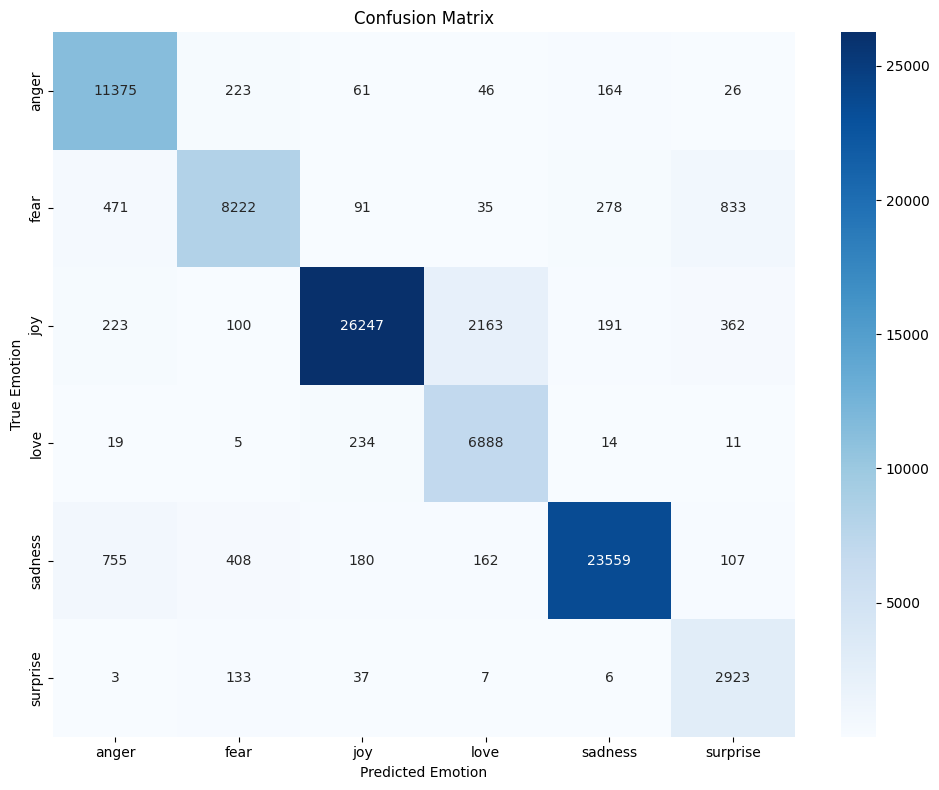

In [5]:
# Define model building function with hyperparameter tuning
def build_model(data, emotion_mapping):
    """Build, train, and evaluate the emotion classification model with hyperparameter tuning"""
    X_train, X_test, y_train, y_test = train_test_split(
        data['processed_text'], data['emotion_id'],
        test_size=0.2, random_state=42, stratify=data['emotion_id']
    )

    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', LogisticRegression())
    ])

    param_grid = {
        'vectorizer__max_features': [5000, 10000],
        'vectorizer__ngram_range': [(1, 2), (1, 3)],
        'vectorizer__min_df': [2, 3],
        'vectorizer__use_idf': [True],
        'vectorizer__sublinear_tf': [True],
        'classifier__C': [1, 10],
        'classifier__max_iter': [1000],
        'classifier__class_weight': ['balanced'],
        'classifier__solver': ['saga'],
        'classifier__multi_class': ['multinomial']
    }

    print("Performing grid search for hyperparameter tuning...")
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=3,
        scoring='accuracy', verbose=1, n_jobs=-1
    )

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    print(f"Model training completed in {end_time - start_time:.2f} seconds")

    best_model = grid_search.best_estimator_
    print(f"Best hyperparameters: {grid_search.best_params_}")

    print("Evaluating model on test set...")
    y_pred = best_model.predict(X_test)

    id_to_emotion = {v: k for k, v in emotion_mapping.items()}
    y_test_labels = [id_to_emotion[i] for i in y_test]
    y_pred_labels = [id_to_emotion[i] for i in y_pred]

    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    report = classification_report(y_test_labels, y_pred_labels)

    print(f"Test set accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=sorted(data['emotion'].unique()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(data['emotion'].unique()),
                yticklabels=sorted(data['emotion'].unique()))
    plt.title('Confusion Matrix')
    plt.ylabel('True Emotion')
    plt.xlabel('Predicted Emotion')
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/confusion_matrix.png')
    plt.show()

    return best_model, X_test, y_test, y_test_labels, y_pred_labels, report

# Build and train the model
model, X_test, y_test, y_test_labels, y_pred_labels, classification_report_text = build_model(data, emotion_mapping)

# **6: Error Analysis**

In [6]:
def analyze_errors(X_test, y_test_labels, y_pred_labels, model, emotion_mapping):
    """Perform detailed error analysis"""
    misclassified_indices = [i for i, (y_true, y_pred) in enumerate(zip(y_test_labels, y_pred_labels)) if y_true != y_pred]

    if not misclassified_indices:
        print("No misclassifications found!")
        return

    X_test_series = pd.Series(X_test.values)
    sample_size = min(10, len(misclassified_indices))
    sampled_indices = np.random.choice(misclassified_indices, sample_size, replace=False)

    error_df = pd.DataFrame({
        'Text': [X_test_series.iloc[idx] for idx in sampled_indices],
        'True_Emotion': [y_test_labels[idx] for idx in sampled_indices],
        'Predicted_Emotion': [y_pred_labels[idx] for idx in sampled_indices]
    })

    id_to_emotion = {v: k for k, v in emotion_mapping.items()}
    for idx, row_idx in enumerate(sampled_indices):
        text = X_test_series.iloc[row_idx]
        probs = model.predict_proba([text])[0]
        emotion_probs = {id_to_emotion[i]: prob for i, prob in enumerate(probs)}
        top_emotions = sorted(emotion_probs.items(), key=lambda x: x[1], reverse=True)[:3]
        for i, (emotion, prob) in enumerate(top_emotions):
            error_df.at[idx, f'Top{i+1}'] = emotion
            error_df.at[idx, f'Prob{i+1}'] = f"{prob:.3f}"

    print("\n--- Error Analysis ---")
    print(f"Total misclassifications: {len(misclassified_indices)} out of {len(y_test_labels)} ({len(misclassified_indices)/len(y_test_labels)*100:.2f}%)")

    confusion_pairs = {}
    for idx in misclassified_indices:
        pair = (y_test_labels[idx], y_pred_labels[idx])
        confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1

    print("\nTop confusion pairs (True -> Predicted):")
    for (true, pred), count in sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {true} -> {pred}: {count} instances")

    print("\nSample of misclassified texts:")
    for _, row in error_df.iterrows():
        print(f"\nText: {row['Text']}")
        print(f"True emotion: {row['True_Emotion']}")
        print(f"Predicted emotion: {row['Predicted_Emotion']} (confidence: {row['Prob1']})")
        print(f"Top alternatives: {row['Top2']} ({row['Prob2']}), {row['Top3']} ({row['Prob3']})")
        print("-" * 50)

    error_df.to_csv('/content/drive/My Drive/error_analysis.csv', index=False)
    print("Error analysis saved to Google Drive as 'error_analysis.csv'")

# Run error analysis
analyze_errors(X_test, y_test_labels, y_pred_labels, model, emotion_mapping)


--- Error Analysis ---
Total misclassifications: 7348 out of 86562 (8.49%)

Top confusion pairs (True -> Predicted):
  joy -> love: 2163 instances
  fear -> surprise: 833 instances
  sadness -> anger: 755 instances
  fear -> anger: 471 instances
  sadness -> fear: 408 instances

Sample of misclassified texts:

Text: validated must feel strange likely way feel
True emotion: fear
Predicted emotion: surprise (confidence: 0.929)
Top alternatives: fear (0.068), joy (0.002)
--------------------------------------------------

Text: really feel dont know faithful
True emotion: joy
Predicted emotion: love (confidence: 0.873)
Top alternatives: joy (0.120), sadness (0.003)
--------------------------------------------------

Text: super excited leaving cause feel like everyone cousin knew much hated
True emotion: sadness
Predicted emotion: anger (confidence: 0.435)
Top alternatives: sadness (0.319), joy (0.208)
--------------------------------------------------

Text: always feel hated nothing co

# **7: Save Model and Results**

In [7]:
def save_model(model, emotion_mapping, model_path, mapping_path, report, report_path):
    """Save the trained model, emotion mapping, and classification report with versioning"""
    try:
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        model_path = model_path.replace('.pkl', f'_{timestamp}.pkl')
        mapping_path = mapping_path.replace('.pkl', f'_{timestamp}.pkl')
        report_path = report_path.replace('.txt', f'_{timestamp}.txt')

        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        with open(mapping_path, 'wb') as f:
            pickle.dump(emotion_mapping, f)
        with open(report_path, 'w') as f:
            f.write(report)

        print(f"Model saved to {model_path}")
        print(f"Emotion mapping saved to {mapping_path}")
        print(f"Classification report saved to {report_path}")
        return model_path, mapping_path, report_path

    except Exception as e:
        print(f"Error saving model: {str(e)}")
        raise

# Define paths for saving
model_path = '/content/drive/My Drive/emotion_model.pkl'
mapping_path = '/content/drive/My Drive/emotion_mapping.pkl'
report_path = '/content/drive/My Drive/classification_report.txt'

# Save everything
saved_model_path, saved_mapping_path, saved_report_path = save_model(
    model, emotion_mapping, model_path, mapping_path, classification_report_text, report_path
)

Model saved to /content/drive/My Drive/emotion_model_20250404_185408.pkl
Emotion mapping saved to /content/drive/My Drive/emotion_mapping_20250404_185408.pkl
Classification report saved to /content/drive/My Drive/classification_report_20250404_185408.txt


# **8: Prediction Function and Testing**

In [8]:
class EmotionPredictor:
    """A class for making emotion predictions with confidence scores"""
    def __init__(self, model, emotion_mapping):
        self.model = model
        self.emotion_mapping = emotion_mapping
        self.id_to_emotion = {v: k for k, v in emotion_mapping.items()}

    def predict(self, text):
        """Predict emotion from text"""
        processed_text = preprocess_text(text)
        emotion_id = self.model.predict([processed_text])[0]
        emotion = self.id_to_emotion[emotion_id]
        probs = self.model.predict_proba([processed_text])[0]
        emotion_probs = {self.id_to_emotion[i]: prob for i, prob in enumerate(probs)}
        sorted_probs = sorted(emotion_probs.items(), key=lambda x: x[1], reverse=True)
        confidence = emotion_probs[emotion]
        margin = confidence - sorted_probs[1][1] if len(sorted_probs) > 1 else confidence
        return {
            'emotion': emotion,
            'confidence': confidence,
            'margin': margin,
            'probabilities': emotion_probs,
            'processed_text': processed_text
        }

    def predict_batch(self, texts):
        """Process a batch of texts and predict emotions"""
        results = []
        for text in texts:
            if text:
                result = self.predict(text)
                result['text'] = text
                results.append(result)
        return results

    def predict_from_file(self, file_path):
        """Process a file with multiple text samples"""
        texts = []
        try:
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
                if 'text' in df.columns:
                    texts = df['text'].tolist()
                else:
                    texts = df.iloc[:, 0].tolist()
            else:
                with open(file_path, 'r', encoding='utf-8') as file:
                    texts = [line.strip() for line in file if line.strip()]
        except Exception as e:
            print(f"Error reading file: {str(e)}")
            return []
        return self.predict_batch(texts)

# Create predictor
predictor = EmotionPredictor(model, emotion_mapping)

# Test with a file
file_path = "/content/drive/MyDrive/dataset/test.csv"

try:
    print(f"\nProcessing samples from {file_path}...")
    results = predictor.predict_from_file(file_path)
    print(f"Processed {len(results)} samples from file:")

    results_df = pd.DataFrame(results)
    results_df['top_emotions'] = results_df['probabilities'].apply(
        lambda x: ', '.join([f"{e}: {p:.3f}" for e, p in sorted(x.items(), key=lambda i: i[1], reverse=True)[:3]])
    )

    display_df = results_df[['text', 'emotion', 'confidence', 'top_emotions']]

    for i, row in display_df.head(5).iterrows():
        print(f"\nSample {i+1}:")
        print(f"Text: {row['text']}")
        print(f"Predicted emotion: {row['emotion']} (confidence: {row['confidence']:.3f})")
        print(f"Top emotions: {row['top_emotions']}")

    results_path = '/content/drive/My Drive/prediction_results.csv'
    display_df.to_csv(results_path, index=False)
    print(f"\nAll results saved to {results_path}")

except Exception as e:
    print(f"Error during prediction: {str(e)}")

print("\nEmotion classification pipeline completed successfully!")


Processing samples from /content/drive/MyDrive/dataset/test.csv...
Processed 1999 samples from file:

Sample 1:
Text: im updating my blog because i feel shitty
Predicted emotion: sadness (confidence: 0.995)
Top emotions: sadness: 0.995, joy: 0.002, anger: 0.001

Sample 2:
Text: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
Predicted emotion: sadness (confidence: 0.771)
Top emotions: sadness: 0.771, joy: 0.123, anger: 0.054

Sample 3:
Text: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
Predicted emotion: joy (confidence: 0.854)
Top emotions: joy: 0.854, sadness: 0.053, anger: 0.048

Sample 4:
Text: i was feeling a little vain when i did this one
Predicted emotion: sadness (confidence: 1.000)
Top emotions: sadness: 1.000, fear: 0.000, joy: 0.000

Sample 5:
Text: i cant walk into a shop anywhere where i do not feel uncomfortable
Predicted emotion: fear (confidence: 0.99